In [59]:
from ta.trend import SMAIndicator

In [60]:
import numpy as np
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go
# Ignore printing all warnings.
import warnings
warnings.filterwarnings('ignore')

In [61]:
class MA_CrossOver:
    
    def __init__(self, symbol, start_date, end_date, STMA_Window, LTMA_Window, interval):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.STMA_Window = STMA_Window
        self.LTMA_Window = LTMA_Window
        self.interval = interval
            
    def prepareData(self):
        tickers = [self.symbol,'^GSPC']
        data = yf.download(tickers, start=self.start_date, end=self.end_date)
        df = data['Close']
        df.rename(columns={'^GSPC':'SP500'}, inplace=True)
        #print(df.head())
        indicator_1 = SMAIndicator(close = df[self.symbol], window= self.STMA_Window, fillna= False)
        STMA = indicator_1.sma_indicator()
        indicator_2 = SMAIndicator(close = df[self.symbol], window= self.LTMA_Window, fillna= False)
        LTMA = indicator_2.sma_indicator()
        
        self.bt_data = pd.DataFrame()
        self.bt_data["Stock_Price"] = df[self.symbol]
        self.bt_data['Benchmark_Price'] = df['SP500']
        self.bt_data["STMA"] = STMA
        self.bt_data["LTMA"] = LTMA
        self.bt_data = self.bt_data.dropna()
        #print(self.bt_data.head())
        
    def strategy(self):
        self.bt_data["Position"] = np.where(self.bt_data['STMA'] > self.bt_data['LTMA'], 1.0, -1.0)
        #print(self.bt_data.head())
        
    def visualise_strategy(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.bt_data.index, self.bt_data['Stock_Price'], label='Stock Price', color='blue', alpha=0.5)
        # Plotting short-term and long-term moving averages
        plt.plot(self.bt_data.index, self.bt_data['STMA'], label=f'{self.STMA_Window}-Day SMA', color='red', alpha=0.75)
        plt.plot(self.bt_data.index, self.bt_data['LTMA'], label=f'{self.LTMA_Window}-Day SMA', color='green', alpha=0.75)
        # Highlighting buy signals (STMA > LTMA)
        buy_signals = self.bt_data[self.bt_data['Position'] == 1.0]
        plt.scatter(buy_signals.index, buy_signals['Stock_Price'], label='Buy Signal', marker='^', color='green', alpha=1)
        # Highlighting sell signals (STMA < LTMA)
        sell_signals = self.bt_data[self.bt_data['Position'] == -1.0]
        plt.scatter(sell_signals.index, sell_signals['Stock_Price'], label='Sell Signal', marker='v', color='red', alpha=1)

        plt.title(f"{self.symbol} Price, {self.STMA_Window}-Day and {self.LTMA_Window}-Day SMA with Buy/Sell Signals")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
    
        plt.show()
    
    def performance(self):
        self.reg_returns = self.bt_data['Stock_Price'].pct_change()
        self.bt_data['Stock_Returns'] = np.log ( 1 + self.reg_returns)
        self.bt_data['Benchmark_Returns'] = np.log ( 1 + self.bt_data['Benchmark_Price'].pct_change())
        self.bt_data["Strategy_Returns"] = self.bt_data["Stock_Returns"] * self.bt_data["Position"].shift(1)
        #print(self.bt_data.head())
        annual_ret = self.bt_data[["Stock_Returns", "Strategy_Returns", "Benchmark_Returns"]].mean() * 252
        annual_regular_ret = np.exp(annual_ret)-1
        print('Annual regular returns are: \n',annual_regular_ret)
        annual_regular_std = (np.exp(self.bt_data[["Stock_Returns", "Strategy_Returns", "Benchmark_Returns"]])-1).std() * (252 **0.5)
        print('Annual regular std is: \n', annual_regular_std)
        sr = annual_regular_ret/ annual_regular_std
        print("The Sharpe Ratio is : \n ", sr)
        result = f"Annual regular returns are: \n{annual_regular_ret}\nAnnual regular std is: \n{annual_regular_std}\nThe Sharpe Ratio is: \n{sr}"
        return result
        
    def returns_plot(self):
        self.bt_data[["Stock_Returns", "Strategy_Returns", "Benchmark_Returns"]].cumsum().plot()
        
    def drawdown_plot(self):
        self.bt_data["Cumulative_Returns"] = self.bt_data["Strategy_Returns"].cumsum()
        self.bt_data["Maximum_Returns"] = self.bt_data["Cumulative_Returns"].cummax()
        self.bt_data["drawdowns"] = self.bt_data["Maximum_Returns"] - self.bt_data["Cumulative_Returns"]
        self.max_drawdown = self.bt_data["drawdowns"].max()
        print("The max drawdown is", self.max_drawdown)
        self.bt_data[["Cumulative_Returns", "Maximum_Returns"]].dropna().plot()

[*********************100%%**********************]  2 of 2 completed


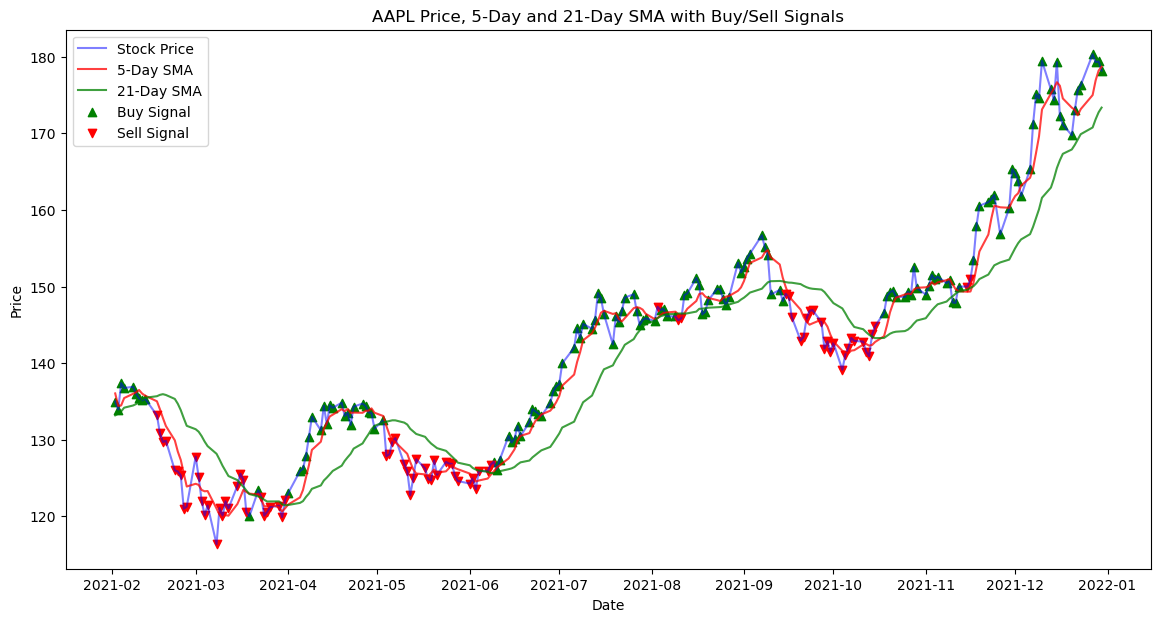

Annual regular returns are: 
 Stock_Returns        0.355634
Strategy_Returns     0.617125
Benchmark_Returns    0.275751
dtype: float64
Annual regular std is: 
 Stock_Returns        0.239086
Strategy_Returns     0.237966
Benchmark_Returns    0.126624
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns        1.487471
Strategy_Returns     2.593328
Benchmark_Returns    2.177711
dtype: float64
The max drawdown is 0.07617453069817508


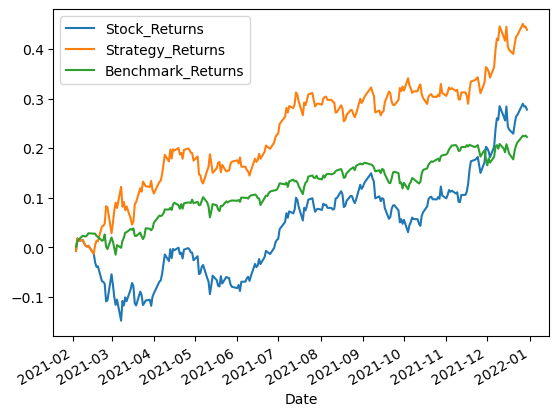

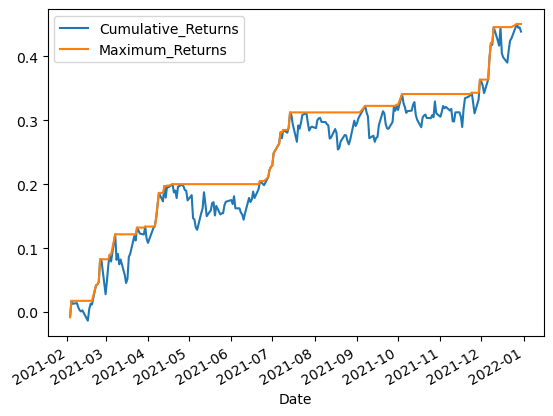

In [62]:
my_object = MA_CrossOver("AAPL", '2021-01-01', '2021-12-31', 5, 21, "1d")
my_object.prepareData()
my_object.strategy()
my_object.visualise_strategy()
my_object.performance()
my_object.returns_plot()
my_object.drawdown_plot()

In [63]:

# Initialize the Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("MA CrossOver Strategy"),
    
    html.Div(
        children=[
            "Strategy Descriptions: When the short-term moving average crosses above the long-term moving average, it triggers a sell signal, indicating potential downward momentum."
        ],
        className='strategy-description',
        style={'margin-bottom': '20px'} 
    ),
    
    html.Div([
        html.Label("Stock Symbol:"),
        dcc.Input(id='symbol', value='AAPL', type='text'),
    ]),
    html.Div([
        html.Label("Start Date:"),
        dcc.Input(id='start_date', value='2021-01-01', type='text'),
    ]),
    html.Div([
        html.Label("End Date:"),
        dcc.Input(id='end_date', value='2021-12-31', type='text'),
    ]),
    html.Div([
        html.Label("STMA Window:"),
        dcc.Input(id='stma_window', value='5', type='number'),
    ]),
    html.Div([
        html.Label("LTMA Window:"),
        dcc.Input(id='ltma_window', value='21', type='number'),
    ]),
    html.Button('Submit', id='submit_val', n_clicks=0),
    html.Div(id='container-button-basic')
])

@app.callback(
    Output('container-button-basic', 'children'),  # Output remains the same
    Input('submit_val', 'n_clicks'),  # Trigger: Only when the submit button is clicked
    [State('symbol', 'value'),  # Using 'State' for inputs, not triggering the callback
     State('start_date', 'value'),
     State('end_date', 'value'),
     State('stma_window', 'value'),
     State('ltma_window', 'value')]
)
def update_output(n_clicks, symbol, start_date, end_date, stma_window, ltma_window):
    if n_clicks > 0:  # Check if button has been clicked (n_clicks is incremented)
        # The same logic to execute strategy goes here
        strategy = MA_CrossOver(symbol, start_date, end_date, int(stma_window), int(ltma_window), '1d')
        strategy.prepareData()
        strategy.strategy()
        result = strategy.performance()  # Assuming this now returns a formatted string
        # Convert newline characters to HTML breaks for display
        formatted_result = result.replace("\n", "<br>")
        return dcc.Markdown(formatted_result, dangerously_allow_html=True)
    return "Enter details and submit to see results."

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns        0.355634
Strategy_Returns     0.617125
Benchmark_Returns    0.275751
dtype: float64
Annual regular std is: 
 Stock_Returns        0.239086
Strategy_Returns     0.237966
Benchmark_Returns    0.126624
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns        1.487471
Strategy_Returns     2.593328
Benchmark_Returns    2.177711
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns        0.355634
Strategy_Returns     0.396520
Benchmark_Returns    0.275751
dtype: float64
Annual regular std is: 
 Stock_Returns        0.239086
Strategy_Returns     0.238814
Benchmark_Returns    0.126624
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns        1.487471
Strategy_Returns     1.660369
Benchmark_Returns    2.177711
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns       -0.019776
Strategy_Returns     0.154930
Benchmark_Returns    0.001801
dtype: float64
Annual regular std is: 
 Stock_Returns        0.306244
Strategy_Returns     0.306001
Benchmark_Returns    0.195450
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns       -0.064577
Strategy_Returns     0.506304
Benchmark_Returns    0.009213
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns       -0.019776
Strategy_Returns     0.163090
Benchmark_Returns    0.001801
dtype: float64
Annual regular std is: 
 Stock_Returns        0.306244
Strategy_Returns     0.305802
Benchmark_Returns    0.195450
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns       -0.064577
Strategy_Returns     0.533319
Benchmark_Returns    0.009213
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns       -0.019776
Strategy_Returns     0.164794
Benchmark_Returns    0.001801
dtype: float64
Annual regular std is: 
 Stock_Returns        0.306244
Strategy_Returns     0.305949
Benchmark_Returns    0.195450
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns       -0.064577
Strategy_Returns     0.538631
Benchmark_Returns    0.009213
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns       -0.042293
Strategy_Returns    -0.297368
Benchmark_Returns    0.001801
dtype: float64
Annual regular std is: 
 Stock_Returns        0.321189
Strategy_Returns     0.319620
Benchmark_Returns    0.195450
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns       -0.131676
Strategy_Returns    -0.930378
Benchmark_Returns    0.009213
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns       -0.019776
Strategy_Returns     0.164794
Benchmark_Returns    0.001801
dtype: float64
Annual regular std is: 
 Stock_Returns        0.306244
Strategy_Returns     0.305949
Benchmark_Returns    0.195450
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns       -0.064577
Strategy_Returns     0.538631
Benchmark_Returns    0.009213
dtype: float64


[*********************100%%**********************]  2 of 2 completed


Annual regular returns are: 
 Stock_Returns        0.355634
Strategy_Returns     0.617125
Benchmark_Returns    0.275751
dtype: float64
Annual regular std is: 
 Stock_Returns        0.239086
Strategy_Returns     0.237966
Benchmark_Returns    0.126624
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns        1.487471
Strategy_Returns     2.593328
Benchmark_Returns    2.177711
dtype: float64
